# Data Loading and Preparing

## Load Required Libraries

In [1]:
# Install pandas if not already installed
import requests
import os
import pandas as pd
from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Geospatial libraries
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None  # default='warn'

# For viewing data frames and copying to presentations
from itables import init_notebook_mode, show
pd.options.display.float_format = '{:,.2f}'.format


In [2]:
# Custom Function for creating a data dictionary 
def data_dictionary(df):
    # Create a data dictionary of the data-types
    datadict = pd.DataFrame(df.dtypes)
    # Rename the Data Type Column 
    datadict = datadict.rename(columns={0:'DataType'})
    # Add a count of missing values
    datadict['MissingVal'] = df.isnull().sum()
    # Add the number of unique values for each attribute (objects count the levels)
    datadict['NUnique']=df.nunique()
    # Add a count for each attribute
    datadict['Count']=df.count()        
    return (datadict)


## Geographic Area of Interest

### Determine the FIPS codes for the metropolitan areas of interest

In [3]:
# Define the list of metro areas of interest
metro_areas = ["Chicago-Naperville-Elgin, IL-IN-WI Metro Area", 
              "Denver-Aurora-Lakewood, CO Metro Area",  
              "Los Angeles-Long Beach-Anaheim, CA Metro Area", 
              "New York-Newark-Jersey City, NY-NJ-PA Metro Area",
              "Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area" 
              ]

short_names = ["Chicago", "Denver", "Los Angeles", "New York", "Washington"]
metro_mapping = pd.DataFrame({'long_name': metro_areas, 'metro_area': short_names})

# Read the MSA county reference file
msa_county_reference17 = pd.read_csv('msa_county_reference17.csv', sep=',')

# Select only the rows that match the metro areas of interest
metro_areas_fips = msa_county_reference17[msa_county_reference17['name_msa'].isin(metro_areas)]

# Create a new column that is the concatenation of the state and county codes
# Conctenate the state and county codes to create a new column 'FIPS'
#  This format ensure the news FIPS code is 5 digits long
metro_areas_fips['fips'] = metro_areas_fips['fipstate'].astype(str).str.zfill(2) + metro_areas_fips['fipscty'].astype(str).str.zfill(3)

# Map the short names to the metro areas
metro_areas_fips = metro_areas_fips.merge(metro_mapping, left_on='name_msa', right_on='long_name', how='inner')
# Select the relevant columns
metro_areas_fips = metro_areas_fips[['fips', 'metro_area']]
# Set the type for each column as category
metro_areas_fips['fips'] = metro_areas_fips['fips'].astype('category')
metro_areas_fips['metro_area'] = metro_areas_fips['metro_area'].astype('category')

# Unique FIPS codes for the selected metro areas
unique_fips = metro_areas_fips[['fips']].drop_duplicates()
#print(unique_fips)
# Print the number of unique FIPS codes
print(f"Number of unique FIPS codes: {len(unique_fips)}")

# Group by metro area and count the number of FIPS codes in each group
grouped_fips = metro_areas_fips.groupby('metro_area', observed=True)['fips'].count().reset_index()

# Print the number of FIPS codes for each metro area
print(grouped_fips)


Number of unique FIPS codes: 75
    metro_area  fips
0      Chicago    14
1       Denver    10
2  Los Angeles     2
3     New York    25
4   Washington    24


## Weather Data Loading and Cleaning

### Create URLS of All Weather Datasets of Interest and Download

In [4]:
weather_type = ["WIND", "TEMP", "PRESS", "RH_DP"]
years = ["2017", "2018", "2019", "2020", "2021"]

weather_urls = []
weather_files = []

# Build URL for each weather type and year
for weather in weather_type:
    for year in years:
        weather_urls.append(f"https://aqs.epa.gov/aqsweb/airdata/hourly_{weather}_{year}.zip")
        weather_files.append(f"hourly_{weather}_{year}.zip")


In [5]:
# Create a folder to store the downloaded files
if not os.path.exists('data'):
    os.makedirs('data')
    
# Custom function to download files
def download_file(url, folder):
    filename = os.path.join(folder, url.split("/")[-1])
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded {filename}") 


In [6]:
#for url in urls:
#    download_file(weather_url, folder="data")


In [7]:
""" ## Investigate the structure of the weather files

# Initialize an empty DataFrame to store column names
weather_columns = pd.DataFrame(columns=["file_name", "columns"])

# Iterate through all weather files
for file in weather_files:
    with ZipFile(f"data/{file}") as zf:
        # Assuming there is only one CSV file in the zip
        csv_filename = [f for f in zf.namelist() if f.endswith('.csv')][0]
        with zf.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            temp_df = pd.read_csv(f, low_memory=False)
            # Append the file name and column names to the DataFrame
            weather_columns = pd.concat([weather_columns, pd.DataFrame({"file_name": [file], "columns": [list(temp_df.columns)]})], ignore_index=True)

# Display the DataFrame with file names and column names
print(weather_columns) """


' ## Investigate the structure of the weather files\n\n# Initialize an empty DataFrame to store column names\nweather_columns = pd.DataFrame(columns=["file_name", "columns"])\n\n# Iterate through all weather files\nfor file in weather_files:\n    with ZipFile(f"data/{file}") as zf:\n        # Assuming there is only one CSV file in the zip\n        csv_filename = [f for f in zf.namelist() if f.endswith(\'.csv\')][0]\n        with zf.open(csv_filename) as f:\n            # Read the CSV file into a DataFrame\n            temp_df = pd.read_csv(f, low_memory=False)\n            # Append the file name and column names to the DataFrame\n            weather_columns = pd.concat([weather_columns, pd.DataFrame({"file_name": [file], "columns": [list(temp_df.columns)]})], ignore_index=True)\n\n# Display the DataFrame with file names and column names\nprint(weather_columns) '

In [8]:
""" # Check if the columns are the same across all files
# Check if all columns are the same across all files
for i in range(len(weather_columns)-1):
    # Compare the columns of the current file with the next one
    if weather_columns['columns'][i] == weather_columns['columns'][i+1]:
        print(f"Columns are the same between {weather_columns['file_name'][i]} and {weather_columns['file_name'][i+1]}")
    else:
        print(f"Columns differ between {weather_columns['file_name'][i]} and {weather_columns['file_name'][i+1]}")
        break """


' # Check if the columns are the same across all files\n# Check if all columns are the same across all files\nfor i in range(len(weather_columns)-1):\n    # Compare the columns of the current file with the next one\n    if weather_columns[\'columns\'][i] == weather_columns[\'columns\'][i+1]:\n        print(f"Columns are the same between {weather_columns[\'file_name\'][i]} and {weather_columns[\'file_name\'][i+1]}")\n    else:\n        print(f"Columns differ between {weather_columns[\'file_name\'][i]} and {weather_columns[\'file_name\'][i+1]}")\n        break '

### Load the zip files as CSVs

In [9]:
"""# Initialize an empty DataFrame to store the results
all_weather_data_dirty = pd.DataFrame()

# Iterate through all NO2 files
for file in weather_files:
    with ZipFile(f"data/{file}") as zf:
        # Assuming there is only one CSV file in the zip
        csv_filename = [f for f in zf.namelist() if f.endswith('.csv')][0]
        with zf.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            temp_df = pd.read_csv(f, low_memory=False)
            # Add the fips code to the temp data frame
            # The FIPS code filtering is done in this block to prevent memory issues
            temp_df['fips'] = temp_df['State Code'].astype(str).str.zfill(2) + temp_df['County Code'].astype(str).str.zfill(3)
            # Create FIPS-Site code column
            temp_df['fips_site'] = temp_df['fips'] + "_" + temp_df['Site Num'].astype(str).str.zfill(4)
            # Filter the DataFrame to include only the rows with FIPS codes in the unique_fips DataFrame
            temp_df = temp_df[temp_df['fips'].isin(unique_fips['fips'])]

            # Append the data to the main DataFrame
            all_weather_data_dirty = pd.concat([all_weather_data_dirty, temp_df], ignore_index=True)"""


'# Initialize an empty DataFrame to store the results\nall_weather_data_dirty = pd.DataFrame()\n\n# Iterate through all NO2 files\nfor file in weather_files:\n    with ZipFile(f"data/{file}") as zf:\n        # Assuming there is only one CSV file in the zip\n        csv_filename = [f for f in zf.namelist() if f.endswith(\'.csv\')][0]\n        with zf.open(csv_filename) as f:\n            # Read the CSV file into a DataFrame\n            temp_df = pd.read_csv(f, low_memory=False)\n            # Add the fips code to the temp data frame\n            # The FIPS code filtering is done in this block to prevent memory issues\n            temp_df[\'fips\'] = temp_df[\'State Code\'].astype(str).str.zfill(2) + temp_df[\'County Code\'].astype(str).str.zfill(3)\n            # Create FIPS-Site code column\n            temp_df[\'fips_site\'] = temp_df[\'fips\'] + "_" + temp_df[\'Site Num\'].astype(str).str.zfill(4)\n            # Filter the DataFrame to include only the rows with FIPS codes in the un

In [10]:
"""# Save for future use as a pickle file
all_weather_data_dirty.to_pickle("all_weather_data_dirty.pkl")"""


'# Save for future use as a pickle file\nall_weather_data_dirty.to_pickle("all_weather_data_dirty.pkl")'

In [11]:
## Load the data from the pickle file
all_weather_data_dirty = pd.read_pickle("all_weather_data_dirty.pkl")


In [12]:
# Describe the data to understand its structure
#all_weather_data_dirty.describe(include='all')
# Print the first few rows of the DataFrame
#print(all_weather_data_dirty.head())


### Clean the Data

In [13]:
weatherFields = ['fips', 'fips_site', 'Latitude', 'Longitude', 'Datum', 
                 'Date Local', 'Time Local',
                 'Parameter Code', 'Parameter Name', 'Sample Measurement']
# Create a new dataframe with the selected columns
all_weather_data = all_weather_data_dirty[weatherFields]

# Rename the columns to remove spaces
all_weather_data.columns = all_weather_data.columns.str.replace(' ', '_')
# Convert the columns to lowercase
all_weather_data.columns = all_weather_data.columns.str.lower()


In [14]:
# Calculate the number of missing values in the parameter_name column
# Display the data dictionary
print(data_dictionary(all_weather_data))


                   DataType  MissingVal  NUnique    Count
fips                 object           0       31  8274514
fips_site            object           0       70  8274514
latitude            float64           0       70  8274514
longitude           float64           0       70  8274514
datum                object           0        2  8274514
date_local           object           0     1826  8274514
time_local           object           0       24  8274514
parameter_code        int64           0        6  8274514
parameter_name       object           0        6  8274514
sample_measurement  float64           0     5089  8274514


### Create Columns for each type of weather measurement

In [15]:
# Pivot the DataFrame to create a wide format
all_weather_data_pivot = all_weather_data.pivot_table(index=['fips','fips_site', 'date_local', 'time_local'], 
                                                              columns='parameter_name', 
                                                              values=['sample_measurement'],
                                                              observed=True,
                                                              fill_value=np.nan).reset_index()

# Flatten the multi-level columns
all_weather_data_pivot.columns = ['_'.join(col).strip() for col in all_weather_data_pivot.columns.values]
# Rename the columns to remove spaces and make them lowercase
all_weather_data_pivot.columns = all_weather_data_pivot.columns.str.replace(' ', '_')
# Convert the columns to lowercase
all_weather_data_pivot.columns = all_weather_data_pivot.columns.str.lower()
# Remove the trailing '_' from the column names
all_weather_data_pivot.columns = all_weather_data_pivot.columns.str.rstrip('_')
# Remove the "-_resultant" suffix from the column names
all_weather_data_pivot.columns = all_weather_data_pivot.columns.str.replace('_-_resultant', '', regex=False)
# Remove the "sample_measurement_" prefix from the column names
all_weather_data_pivot.columns = all_weather_data_pivot.columns.str.replace('sample_measurement_', '', regex=False)

# Print the first few rows of the pivoted data
#print(all_weather_data_pivot.head())
# Describe the pivoted data to understand its structure
all_weather_data_pivot.describe(include='all')


,fips,fips_site,date_local,time_local,barometric_pressure,dew_point,outdoor_temperature,relative_humidity,wind_direction,wind_speed
count,2272647,2272647,2272647,2272647,"1,077,291.00","74,291.00","2,030,786.00","1,368,719.00","1,768,482.00","1,780,250.00"
unique,31,70,1826,24,NaN,NaN,NaN,NaN,NaN,NaN
top,06037,06037_1602,2017-04-02,16:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,589539,43818,1440,94770,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,994.01,39.73,57.47,60.54,186.37,4.02
std,NaN,NaN,NaN,NaN,46.24,19.96,17.69,23.25,98.57,35.95
min,NaN,NaN,NaN,NaN,0.00,-38.00,-27.00,0.00,0.00,0.00
25%,NaN,NaN,NaN,NaN,995.00,25.00,45.00,43.00,105.00,1.60
50%,NaN,NaN,NaN,NaN,"1,006.00",38.00,59.70,63.00,197.00,3.10
75%,NaN,NaN,NaN,NaN,"1,013.00",57.00,70.00,80.00,264.00,5.40


In [16]:
# Show the data dictionary for the pivoted data
print(data_dictionary(all_weather_data_pivot))


                    DataType  MissingVal  NUnique    Count
fips                  object           0       31  2272647
fips_site             object           0       70  2272647
date_local            object           0     1826  2272647
time_local            object           0       24  2272647
barometric_pressure  float64     1195356     1403  1077291
dew_point            float64     2198356      119    74291
outdoor_temperature  float64      241861     1184  2030786
relative_humidity    float64      903928      905  1368719
wind_direction       float64      504165     3601  1768482
wind_speed           float64      492397     1039  1780250


In [17]:
# Create a table of the descriptive statistics for numeric columns
# Print the descriptive statistics for numeric columns
print(all_weather_data_pivot.describe(include='number'))


       barometric_pressure  dew_point  outdoor_temperature  relative_humidity  \
count         1,077,291.00  74,291.00         2,030,786.00       1,368,719.00   
mean                994.01      39.73                57.47              60.54   
std                  46.24      19.96                17.69              23.25   
min                   0.00     -38.00               -27.00               0.00   
25%                 995.00      25.00                45.00              43.00   
50%               1,006.00      38.00                59.70              63.00   
75%               1,013.00      57.00                70.00              80.00   
max               1,043.70      81.00               117.50             100.00   

       wind_direction   wind_speed  
count    1,768,482.00 1,780,250.00  
mean           186.37         4.02  
std             98.57        35.95  
min              0.00         0.00  
25%            105.00         1.60  
50%            197.00         3.10  
75%        

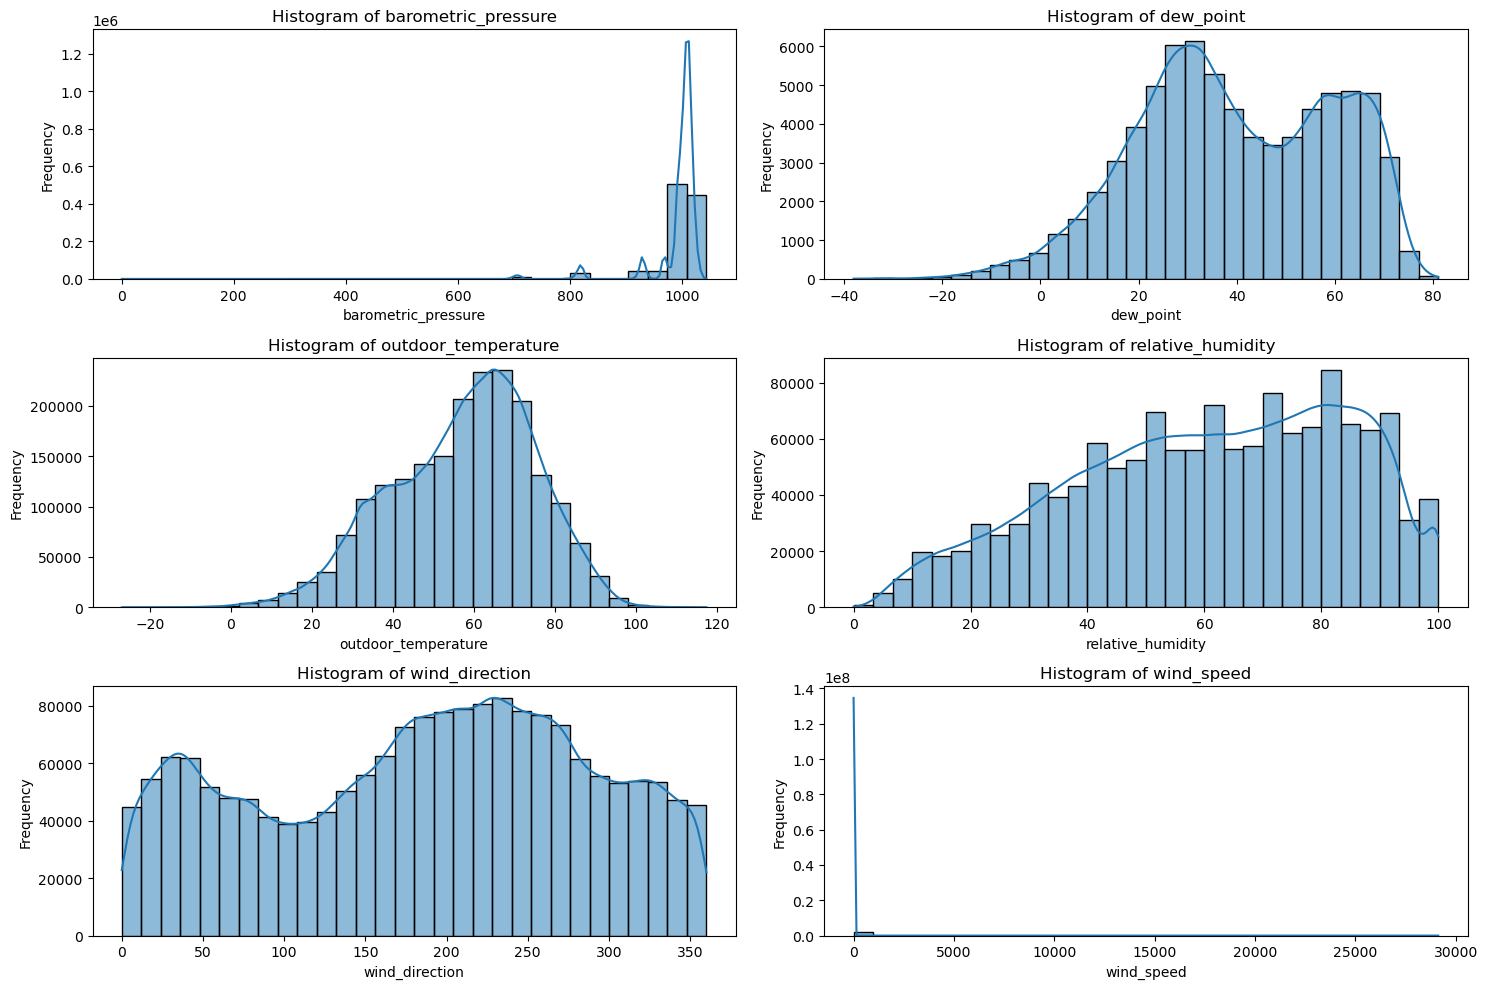

In [18]:
# Plot histograms of the weather data in a 3 by 2 grid
# List of columns to plot from the pivoted DataFrame
columns_to_plot = ['barometric_pressure', 'dew_point', 'outdoor_temperature', 'relative_humidity', 'wind_direction', 'wind_speed']

# Create a 3 by 2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
# Flatten the axes array for easy indexing
axes = axes.flatten()
# Iterate through the columns and plot histograms
for i, col in enumerate(columns_to_plot):
    # Plot the histogram for each column
    sns.histplot(all_weather_data_pivot[col], bins=30, kde=True, ax=axes[i])
    # Set the title and labels
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()


In [19]:
# Show the data dictionary for the pivoted data
print(data_dictionary(all_weather_data_pivot))


                    DataType  MissingVal  NUnique    Count
fips                  object           0       31  2272647
fips_site             object           0       70  2272647
date_local            object           0     1826  2272647
time_local            object           0       24  2272647
barometric_pressure  float64     1195356     1403  1077291
dew_point            float64     2198356      119    74291
outdoor_temperature  float64      241861     1184  2030786
relative_humidity    float64      903928      905  1368719
wind_direction       float64      504165     3601  1768482
wind_speed           float64      492397     1039  1780250


### Dealing with outliers

In [20]:
# Filter the data to find wind speed greater than 3sd from the mean
#all_weather_data_pivot['wind_speed'] = all_weather_data_pivot['wind_speed'].astype(float)
# Calculate the mean and standard deviation for wind speed
mean_wind_speed = all_weather_data_pivot['wind_speed'].mean()
std_wind_speed = all_weather_data_pivot['wind_speed'].std()
# Calculate the threshold for 3 standard deviations
#threshold = mean_wind_speed + 1 * std_wind_speed
threshold = 47.0 # Gale force wind speed threshold
# Filter the data to find wind speed greater than 3 standard deviations from the mean
high_wind_speed = all_weather_data_pivot[all_weather_data_pivot['wind_speed'] > threshold]
# Sort by wind speed in descending order
high_wind_speed = high_wind_speed.sort_values(by='wind_speed', ascending=False)
# Print the high wind speed data
print(high_wind_speed[['fips', 'fips_site', 'date_local', 'wind_speed']])
# Print the number of rows with high wind speed
print(f"Number of rows with high wind speed: {len(high_wind_speed)}")


          fips   fips_site  date_local  wind_speed
2064337  36081  36081_0124  2019-04-26   29,131.30
2065157  36081  36081_0124  2019-05-31   29,124.60
2065155  36081  36081_0124  2019-05-30   18,489.90
2062119  36081  36081_0124  2019-01-23   10,917.30
2065161  36081  36081_0124  2019-05-31    7,769.60
...        ...         ...         ...         ...
1215355  08059  08059_0006  2020-01-04       48.30
874237   08005  08005_0006  2019-03-13       48.20
1207221  08059  08059_0006  2019-01-27       47.80
1215356  08059  08059_0006  2020-01-05       47.30
1207628  08059  08059_0006  2019-02-13       47.20

[103 rows x 4 columns]
Number of rows with high wind speed: 103


In [21]:
# Create grouped data for high wind speed
high_wind_speed_grouped = high_wind_speed.groupby(['fips', 'fips_site'], observed=True)['wind_speed'].count().reset_index()
# Rename the columns
high_wind_speed_grouped = high_wind_speed_grouped.rename(columns={'wind_speed': 'count'})

# Print the results
print(high_wind_speed_grouped)
print(high_wind_speed_grouped['count'].sum())


    fips   fips_site  count
0  08005  08005_0006      3
1  08059  08059_0006     18
2  17031  17031_3103      5
3  36081  36081_0124     77
103


In [22]:
print(data_dictionary(all_weather_data_pivot))


                    DataType  MissingVal  NUnique    Count
fips                  object           0       31  2272647
fips_site             object           0       70  2272647
date_local            object           0     1826  2272647
time_local            object           0       24  2272647
barometric_pressure  float64     1195356     1403  1077291
dew_point            float64     2198356      119    74291
outdoor_temperature  float64      241861     1184  2030786
relative_humidity    float64      903928      905  1368719
wind_direction       float64      504165     3601  1768482
wind_speed           float64      492397     1039  1780250


In [23]:
# Filter all rows that have a missing wind speed value
missing_wind_speed = all_weather_data_pivot[all_weather_data_pivot['wind_speed'].isnull()]
# Replace the NaN values with 1 for counting purposes
missing_wind_speed['wind_speed'] = missing_wind_speed['wind_speed'].fillna(1)

# Print the head
#print(missing_wind_speed.head())

# Print the data dictionary for the missing wind speed data
#print(data_dictionary(missing_wind_speed))

# Group by fips_site and count the number of missing values
missing_wind_speed_grouped = missing_wind_speed.groupby(['fips_site'], observed=True)['wind_speed'].count().reset_index()
# Sorty by wind_speed in descending order
missing_wind_speed_grouped = missing_wind_speed_grouped.sort_values(by='wind_speed', ascending=False)

#Print the results
print(missing_wind_speed_grouped)


     fips_site  wind_speed
50  36059_0005       43750
13  06037_9033       43702
48  36005_0110       42502
59  36119_2004       32621
35  17031_4201       31962
..         ...         ...
10  06037_4008           5
41  24033_0030           3
44  34013_0003           1
34  17031_3103           1
11  06037_4009           1

[63 rows x 2 columns]


In [24]:
# Remove the outliers from the wind speed data
# Replace all missing wind speed values with -99 for filtering purposes
all_weather_data_pivot['wind_speed'] = all_weather_data_pivot['wind_speed'].fillna(-99)
all_weather_data_pivot = all_weather_data_pivot[all_weather_data_pivot['wind_speed'] <= threshold]

# Remove the -99 values from the wind speed data
all_weather_data_pivot['wind_speed'] = all_weather_data_pivot['wind_speed'].replace(-99, np.nan)
# Print the descriptive statistics for numeric columns
# Drop the index
all_weather_data_pivot = all_weather_data_pivot.reset_index(drop=True)
# Print the descriptive statistics for numeric columns
#all_weather_data_pivot.info()

# Show the data dictionary for the pivoted data
print(data_dictionary(all_weather_data_pivot))


                    DataType  MissingVal  NUnique    Count
fips                  object           0       31  2272544
fips_site             object           0       70  2272544
date_local            object           0     1826  2272544
time_local            object           0       24  2272544
barometric_pressure  float64     1195338     1399  1077206
dew_point            float64     2198253      119    74291
outdoor_temperature  float64      241856     1184  2030688
relative_humidity    float64      903843      905  1368701
wind_direction       float64      504165     3601  1768379
wind_speed           float64      492397      937  1780147


### Group the weather data by date and FIPS-Site to calculate daily average

In [25]:
# Show the pivot data info
print(all_weather_data_pivot.describe(include='all'))


           fips   fips_site  date_local time_local  barometric_pressure  \
count   2272544     2272544     2272544    2272544         1,077,206.00   
unique       31          70        1826         24                  NaN   
top       06037  06037_1602  2017-04-02      16:00                  NaN   
freq     589539       43818        1440      94765                  NaN   
mean        NaN         NaN         NaN        NaN               994.01   
std         NaN         NaN         NaN        NaN                46.24   
min         NaN         NaN         NaN        NaN                 0.00   
25%         NaN         NaN         NaN        NaN               995.00   
50%         NaN         NaN         NaN        NaN             1,006.00   
75%         NaN         NaN         NaN        NaN             1,013.00   
max         NaN         NaN         NaN        NaN             1,043.70   

        dew_point  outdoor_temperature  relative_humidity  wind_direction  \
count   74,291.00     

In [26]:
# Group by fips, fips_site, and date_local and calculate the mean of the numerical columns
all_weather_data_daily = all_weather_data_pivot.groupby(['fips', 'fips_site', 'date_local'], observed=True)[columns_to_plot].mean().reset_index()

# Print the data dictionary for the daily data
print(data_dictionary(all_weather_data_daily))


                    DataType  MissingVal  NUnique  Count
fips                  object           0       31  95069
fips_site             object           0       70  95069
date_local            object           0     1826  95069
barometric_pressure  float64       50013     9637  45056
dew_point            float64       91818     1789   3251
outdoor_temperature  float64       10046    13159  85023
relative_humidity    float64       37813     8549  57256
wind_direction       float64       20846    24414  74223
wind_speed           float64       20402     6521  74667


In [27]:
# Reset the index
all_weather_data_daily = all_weather_data_daily.reset_index(drop=True)
# Add the metro area to the daily data
all_weather_data_daily = all_weather_data_daily.merge(metro_areas_fips[['fips', 'metro_area']], on='fips', how='left').reset_index(drop=True)


In [28]:
# Convert date_local to datetime format
all_weather_data_daily['date_local'] = pd.to_datetime(all_weather_data_daily['date_local'], format='%Y-%m-%d')

# Convert the fips, fips_site, and metro area columns to category type
all_weather_data_daily['fips'] = all_weather_data_daily['fips'].astype('category')
all_weather_data_daily['fips_site'] = all_weather_data_daily['fips_site'].astype('category')
all_weather_data_daily['metro_area'] = all_weather_data_daily['metro_area'].astype('category')

# Describe the data to understand its structure
print(data_dictionary(all_weather_data_daily))

# Show for power point
show(data_dictionary(all_weather_data_daily))


                           DataType  MissingVal  NUnique  Count
fips                       category           0       31  95069
fips_site                  category           0       70  95069
date_local           datetime64[ns]           0     1826  95069
barometric_pressure         float64       50013     9637  45056
dew_point                   float64       91818     1789   3251
outdoor_temperature         float64       10046    13159  85023
relative_humidity           float64       37813     8549  57256
wind_direction              float64       20846    24414  74223
wind_speed                  float64       20402     6521  74667
metro_area                 category           0        5  95069


In [29]:
# How many rows have all the weather data?
# Remove barometric pressure rows and dew point columns
all_weather_data_daily_full = all_weather_data_daily.drop(columns=['barometric_pressure', 'dew_point'])
# Remove rows with any NA values
all_weather_data_daily_full = all_weather_data_daily_full.dropna()
# Print the number of rows with all weather data
print(f"Number of rows with all weather data: {len(all_weather_data_daily_full)}")
# Print the number of rows with any weather data
print(f"Number of rows with any weather data: {len(all_weather_data_daily)}")
# Print the number of rows with missing weather data
print(f"Number of rows with missing weather data: {len(all_weather_data_daily) - len(all_weather_data_daily_full)}")

# Print the data dictionary for the daily data
print(data_dictionary(all_weather_data_daily_full))


Number of rows with all weather data: 46814
Number of rows with any weather data: 95069
Number of rows with missing weather data: 48255
                           DataType  MissingVal  NUnique  Count
fips                       category           0       11  46814
fips_site                  category           0       34  46814
date_local           datetime64[ns]           0     1826  46814
outdoor_temperature         float64           0    11038  46814
relative_humidity           float64           0     6105  46814
wind_direction              float64           0    12835  46814
wind_speed                  float64           0     4254  46814
metro_area                 category           0        5  46814


In [30]:
import pickle
# Save the Data Frame as a pickle file
with open('all_weather_data.pkl', 'wb') as file:
    pickle.dump(all_weather_data, file)

#with open('all_weather_data_pivot.pkl', 'wb') as file:
#    pickle.dump(all_weather_data_pivot, file)

with open('all_weather_data_daily.pkl', 'wb') as file:
    pickle.dump(all_weather_data_daily, file)


## $NO_2$ Data Loading and Cleaning

### Create URLS of All Datasets of Interest and Download

In [31]:
NO2_urls = []
NO2_files = []

# Build URL for each weather type and year
for year in years:
    NO2_urls.append(f"https://aqs.epa.gov/aqsweb/airdata/daily_42602_{year}.zip")
    NO2_files.append(f"daily_42602_{year}.zip")


In [32]:
# Download the data for each year
#for url in urls:
#    download_file(url, folder="data")


### Load the zip files as CSVs

In [33]:
"""# Initialize an empty DataFrame to store the results
all_NO2_data_dirty = pd.DataFrame()

# Iterate through all NO2 files
for file in NO2_files:
    with ZipFile(f"data/{file}") as zf:
        # Assuming there is only one CSV file in the zip
        csv_filename = [f for f in zf.namelist() if f.endswith('.csv')][0]
        with zf.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            temp_df = pd.read_csv(f, low_memory=False)
            # The FIPS code filtering is done in this block to prevent memory issues
            temp_df['fips'] = temp_df['State Code'].astype(str).str.zfill(2) + temp_df['County Code'].astype(str).str.zfill(3)
            # Create FIPS-Site code column
            temp_df['fips_site'] = temp_df['fips'] + "_" + temp_df['Site Num'].astype(str).str.zfill(4)
            # Append the data to the main DataFrame
            all_NO2_data_dirty = pd.concat([all_NO2_data_dirty, temp_df], ignore_index=True)"""


'# Initialize an empty DataFrame to store the results\nall_NO2_data_dirty = pd.DataFrame()\n\n# Iterate through all NO2 files\nfor file in NO2_files:\n    with ZipFile(f"data/{file}") as zf:\n        # Assuming there is only one CSV file in the zip\n        csv_filename = [f for f in zf.namelist() if f.endswith(\'.csv\')][0]\n        with zf.open(csv_filename) as f:\n            # Read the CSV file into a DataFrame\n            temp_df = pd.read_csv(f, low_memory=False)\n            # The FIPS code filtering is done in this block to prevent memory issues\n            temp_df[\'fips\'] = temp_df[\'State Code\'].astype(str).str.zfill(2) + temp_df[\'County Code\'].astype(str).str.zfill(3)\n            # Create FIPS-Site code column\n            temp_df[\'fips_site\'] = temp_df[\'fips\'] + "_" + temp_df[\'Site Num\'].astype(str).str.zfill(4)\n            # Append the data to the main DataFrame\n            all_NO2_data_dirty = pd.concat([all_NO2_data_dirty, temp_df], ignore_index=True)'

In [34]:
# Save for future use as a pickle file
#all_NO2_data_dirty.to_pickle("all_NO2_data_dirty.pkl")


In [35]:
# Load the data from the pickle file
all_NO2_data_dirty = pd.read_pickle("all_NO2_data_dirty.pkl")


In [36]:
#all_NO2_data_dirty.describe(include='all')


In [37]:
# Select the relevant columns from the NO2 DataFrame
NO2_fields = ['fips', 'fips_site', 'POC', 'Latitude', 'Longitude', 'Datum',  
'Date Local', 
'Observation Count', 'Observation Percent', 'Arithmetic Mean', '1st Max Value', '1st Max Hour', 'AQI']

# Only select relevant columns
all_NO2_data = all_NO2_data_dirty[NO2_fields]
# Rename the columns to remove spaces
all_NO2_data.columns = all_NO2_data.columns.str.replace(' ', '_')
# Rename the columns to lowercase
all_NO2_data.columns = all_NO2_data.columns.str.lower()


In [38]:
type_dict = {'poc': 'category',
             'latitude': 'float32',
             'longitude': 'float32',
             'datum': 'category',
             'date_local': 'datetime64[ns]',
             'observation_count': 'int16',
             'observation_percent': 'float32',
             'arithmetic_mean': 'float32',
             '1st_max_value': 'float32',
             '1st_max_hour': 'int8',
             'aqi': 'int8',
             'fips': 'category',
             'fips_site': 'category'}
all_NO2_data = all_NO2_data.astype(type_dict) 

# Rename 'arithmetic_mean' to 'N02_concentration' in all_NO2_data DataFrame
all_NO2_data.rename(columns={'arithmetic_mean': 'NO2_concentration'}, inplace=True)

# Display basic information about the DataFrame
print("Basic Information:")
print(all_NO2_data.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783664 entries, 0 to 783663
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fips                 783664 non-null  category      
 1   fips_site            783664 non-null  category      
 2   poc                  783664 non-null  category      
 3   latitude             783664 non-null  float32       
 4   longitude            783664 non-null  float32       
 5   datum                783664 non-null  category      
 6   date_local           783664 non-null  datetime64[ns]
 7   observation_count    783664 non-null  int16         
 8   observation_percent  783664 non-null  float32       
 9   NO2_concentration    783664 non-null  float32       
 10  1st_max_value        783664 non-null  float32       
 11  1st_max_hour         783664 non-null  int8          
 12  aqi                  783664 non-null  int8          


In [39]:
# Group by fips and count the number of NO2  in each group
grouped_NO2 = all_NO2_data.groupby('fips', observed=True)['NO2_concentration'].count().reset_index()
# Print the number of NO2 in each group
print(grouped_NO2)

# Sum all the counts    
grouped_NO2['NO2_concentration'].sum()


      fips  NO2_concentration
0    01073               3531
1    02090                939
2    04013              10353
3    04019               3626
4    05035               1816
..     ...                ...
275  56037               4564
276  56039               1142
277  56041               1333
278  72025                672
279  72061                675

[280 rows x 2 columns]


783664

In [40]:
# Filter the grouped data by the unique FIPS codes
grouped_NO2 = grouped_NO2[grouped_NO2['fips'].isin(unique_fips['fips'])]
# Print the grouped NO2 data
print(grouped_NO2)


      fips  NO2_concentration
14   06037              26483
20   06059               5572
39   08001               1725
42   08031               7086
44   08059               1059
46   08093                409
53   11001               7910
67   17031               7482
70   18089               1703
102  24033               1810
135  34003               1805
138  34013               1814
139  34017               3464
140  34023               1812
141  34027               1825
142  34039               1814
149  36005               3536
153  36081               3555
154  36103                408
244  51013               1813
246  51059               1821
248  51107               1795
250  51153               1795
260  55059                321


### Filtering of FIPS Codes for area of interest

In [41]:
# Filter the dataframe for the FIPS codes in unique FIPS codes
all_NO2_data = all_NO2_data[all_NO2_data['fips'].isin(unique_fips['fips'])]

# Describe the data to understand its structure
all_NO2_data.describe(include='all')


,fips,fips_site,poc,latitude,longitude,datum,date_local,observation_count,observation_percent,NO2_concentration,1st_max_value,1st_max_hour,aqi
count,88817,88817,"88,817.00","88,817.00","88,817.00",88817,88817,"88,817.00","88,817.00","88,817.00","88,817.00","88,817.00","88,817.00"
unique,24,57,5.00,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,06037,06037_1103,1.00,NaN,NaN,WGS84,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,26483,2739,"74,183.00",NaN,NaN,67480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,37.98,-95.60,NaN,2019-07-26 14:31:33.124064256,23.33,97.28,13.58,25.51,11.39,23.69
min,NaN,NaN,NaN,33.67,-118.53,NaN,2017-01-01 00:00:00,1.00,4.00,-1.67,-1.30,0.00,0.00
25%,NaN,NaN,NaN,34.13,-117.95,NaN,2018-04-22 00:00:00,23.00,96.00,6.81,14.70,5.00,13.00
50%,NaN,NaN,NaN,38.97,-87.81,NaN,2019-08-17 00:00:00,24.00,100.00,11.88,24.50,8.00,23.00
75%,NaN,NaN,NaN,40.73,-76.95,NaN,2020-10-25 00:00:00,24.00,100.00,18.62,34.70,19.00,32.00
max,NaN,NaN,NaN,42.50,-73.14,NaN,2021-12-31 00:00:00,24.00,100.00,70.62,131.00,23.00,107.00


### Clean the Data

#### How Many FIPS-Sites have multiple measurements on the same day?

In [42]:
# Group by fips-site and date to count the number of unique POCs
unique_pocs_date = all_NO2_data.groupby(['fips_site', 'date_local'], observed=True).agg({'poc': 'nunique'}).reset_index()
# Rename the columns for clarity
unique_pocs_date.rename(columns={'poc': 'unique_pocs'}, inplace=True)
# List the fips-sites with POCs greater than 1
unique_pocs_date = unique_pocs_date[unique_pocs_date['unique_pocs'] > 1]

# Group by fips-site and count the number of unique dates
unique_dates_fips = unique_pocs_date.groupby('fips_site', observed=True).agg({'date_local': 'nunique'}).reset_index()
# filter for fips-sites with more than 1 date
unique_dates_fips = unique_dates_fips[unique_dates_fips['date_local'] > 1]

# Print the result
print("FIPS-Sites with multiple POCs on the same day:")
print(unique_dates_fips)


FIPS-Sites with multiple POCs on the same day:
    fips_site  date_local
0  06037_1103         914
1  11001_0043         637


#### How different are these observations?

In [43]:
# Filter the all_NO2_data DataFrame to include only the fips-sites with multiple POCs on the same day
filtered_all_NO2_data = all_NO2_data[all_NO2_data['fips_site'].isin(unique_dates_fips['fips_site'])]
# Group by fips-site and date and calculate the minimum and maximum NO2 concentration
poc_compare = filtered_all_NO2_data.groupby(['fips_site', 'date_local'], observed=True).agg({'NO2_concentration': ['min', 'max']}).reset_index()
# Add a column for the difference between max and min NO2 concentration
poc_compare['NO2_diff'] = poc_compare[('NO2_concentration', 'max')] - poc_compare[('NO2_concentration', 'min')]
# Filter for fips-sites with a difference greater than 0
poc_compare = poc_compare[poc_compare['NO2_diff'] > 0]
# Rename the columns for clarity
poc_compare.columns = ['fips_site', 'date_local', 'NO2_min', 'NO2_max', 'NO2_diff']

# Group by fips-site and calculate the mean difference in NO2 concentration
mean_diff = poc_compare.groupby('fips_site', observed=False)['NO2_diff'].mean().reset_index()
mean_diff = mean_diff[mean_diff['NO2_diff'] > 0]
# Pringgt the result
print("Mean difference in NO2 concentration for fips-sites with multiple POCs on the same day:")
print(mean_diff)


Mean difference in NO2 concentration for fips-sites with multiple POCs on the same day:
      fips_site  NO2_diff
45   06037_1103      1.37
149  11001_0043      1.06


#### Average all $NO_2$ Concentrations for each FIPS site by day

In [44]:
# Average NO2 concentration by fips-site and date
avg_NO2_daily = all_NO2_data.groupby(['fips', 'fips_site', 'date_local', 'latitude', 'longitude'], observed=True).agg({'NO2_concentration': 'mean'}).reset_index()
# Rename the columns for clarity
avg_NO2_daily.columns = ['fips', 'fips_site', 'date_local', 'latitude', 'longitude',  'NO2_concentration']


In [45]:
# Calculate the number of unique FIPS_site combinations
num_unique_fips_sites = len(avg_NO2_daily['fips_site'].unique())
# Print the number of unique FIPS_site combinations
print(f"Number of unique FIPS_site combinations: {num_unique_fips_sites}")


Number of unique FIPS_site combinations: 57


#### How bad are negative or low NO2 concentrations

In [46]:
# Create a data-frame with all NO2 concentrations less than or equal to 1
NO2_zero = all_NO2_data[all_NO2_data['NO2_concentration'] <= 1]
print("Number of NO2 concentrations less than or equal to 1:")
print(len(NO2_zero))

# Group by fips-site and count the number of NO2 concentrations less than or equal to 1
grouped_data = NO2_zero.groupby('fips_site', observed=False).size().reset_index(name='count')
grouped_data = grouped_data[grouped_data['count'] > 0]

# Group by fips-site and calculate the mean NO2 concentration
mean_NO2_zero = NO2_zero.groupby('fips_site', observed=False)['NO2_concentration'].mean().reset_index()
mean_NO2_zero = mean_NO2_zero[mean_NO2_zero['NO2_concentration'] < 1]

# Merge the grouped data with the mean NO2 concentration data
grouped_data = grouped_data.merge(mean_NO2_zero, on='fips_site', how='left')

print("FIPS-Sites with NO2 concentrations less than or equal to 1:")
print(grouped_data)


Number of NO2 concentrations less than or equal to 1:
1103
FIPS-Sites with NO2 concentrations less than or equal to 1:
     fips_site  count  NO2_concentration
0   06037_0016      3               0.70
1   06037_0113      5               0.50
2   06037_1201      1               0.82
3   06037_2005      2               0.35
4   06037_4008      2               0.71
5   06037_4010      1               0.59
6   06037_5005     36               0.76
7   06037_6012      3               0.70
8   06037_9033     58              -0.13
9   06059_0007      1               0.72
10  08001_3001      1              -0.18
11  08059_0006    140               0.59
12  08093_0002    269               0.58
13  11001_0043      2               0.92
14  17031_3103      1               0.53
15  18089_0022     42               0.42
16  24033_0030      2               0.89
17  34023_0011      2               0.62
18  34027_3001    470               0.51
19  36103_0044     15               0.85
20  51107_1005      

In [47]:
# Remove any rows with values less than 1 in the NO2_concentration column
avg_NO2_daily = avg_NO2_daily[avg_NO2_daily['NO2_concentration'] > 1]

# Drop all rows with NnA for NO2_concentration
avg_NO2_daily.dropna(subset=['NO2_concentration'], inplace=True)


In [48]:
# Add the metro arae to the avg_NO2_daily DataFrame
avg_NO2_daily = avg_NO2_daily.merge(metro_areas_fips[['fips', 'metro_area']], on='fips', how='left')


### Create multiple data times for later analysis

In [49]:
# Set the date column to datetime format
avg_NO2_daily['date_local'] = pd.to_datetime(avg_NO2_daily['date_local'])
# Set the date column as the index
avg_NO2_daily.set_index('date_local', inplace=True)

# Create a column for month and year
avg_NO2_daily['month_year'] = avg_NO2_daily.index.to_period('M')
# Create a column for year
avg_NO2_daily['year'] = avg_NO2_daily.index.year
# Create a column for week of the year
avg_NO2_daily['week_of_year'] = avg_NO2_daily.index.isocalendar().week
# Add a column for the day of the year
avg_NO2_daily['day_of_year'] = avg_NO2_daily.index.dayofyear

# Add a column for the day of the week
avg_NO2_daily['day_of_week'] = avg_NO2_daily.index.day_name()
# Add a column for the day of the week number
avg_NO2_daily['day_of_week_num'] = avg_NO2_daily.index.dayofweek
# Add a column for the day of the year as a sin function
avg_NO2_daily['day_of_week_sin'] = np.sin(2 * np.pi * avg_NO2_daily['day_of_week_num'] / 7)
# Add a column for the day of the year as a cos function
avg_NO2_daily['day_of_week_cos'] = np.cos(2 * np.pi * avg_NO2_daily['day_of_week_num'] / 7)

# Add a column for weekday/weekend
avg_NO2_daily['weekday'] = np.where(avg_NO2_daily['day_of_week_num'] < 5, 'weekday', 'weekend')

# Add a column for the day of the year as a sin function
avg_NO2_daily['day_of_year_sin'] = np.sin(2 * np.pi * avg_NO2_daily['day_of_year'] / 365.25)
# Add a column for the day of the year as a cos function
avg_NO2_daily['day_of_year_cos'] = np.cos(2 * np.pi * avg_NO2_daily['day_of_year'] / 365.25)

# Sort the data by date_local
avg_NO2_daily.sort_index(inplace=True)


### Create a listing of FIPS-Sites with latitude and longitude for Map views

In [50]:
# group by fips_site select all unique latitude and longitude values
fips_site_locations = all_NO2_data.groupby(['fips', 'fips_site'], observed=True).agg({'latitude': 'first', 'longitude': 'first'}).reset_index()
# Add the metro_area to the dataframe from the metro_areas_fips dataframe
fips_site_locations = fips_site_locations.merge(metro_areas_fips[['fips', 'metro_area']], on='fips', how='left')

# Convert fips and metro_area to category type
fips_site_locations['fips'] = fips_site_locations['fips'].astype('category')
fips_site_locations['metro_area'] = fips_site_locations['metro_area'].astype('category')

print("Grouped DataFrame:")
print(fips_site_locations.head())


Grouped DataFrame:
    fips   fips_site  latitude  longitude   metro_area
0  06037  06037_0002     34.14    -117.92  Los Angeles
1  06037  06037_0016     34.14    -117.85  Los Angeles
2  06037  06037_0113     34.05    -118.46  Los Angeles
3  06037  06037_1103     34.07    -118.23  Los Angeles
4  06037  06037_1201     34.20    -118.53  Los Angeles


### Save the results pickle file for later use in EDA

In [51]:
# Save the all_NO2_data DataFrame as a pickle file
with open('avg_NO2_daily.pkl', 'wb') as file:
    pickle.dump(avg_NO2_daily, file)

# Save the fips_site_locations DataFrame as a pickle file
with open('fips_site_locations.pkl', 'wb') as file:
    pickle.dump(fips_site_locations, file)


# Interactive Maps of Yearly Average Difference of FIPS Sites from 2019 to 2020

In [52]:
# Calculate the mean difference between NO2 concentrations for 2019 and 2020 for each fips-site
avg_NO2_daily_fips = avg_NO2_daily.groupby(['fips', 'fips_site', 'year'], observed=True).agg({'NO2_concentration': 'mean'}).reset_index()
# Rename the columns for clarity
avg_NO2_daily_fips.columns = ['fips', 'fips_site', 'year', 'NO2_concentration']
# Filter the data for 2019 and 2020
avg_NO2_daily_fips = avg_NO2_daily_fips[avg_NO2_daily_fips['year'].isin([2019, 2020])] 
# Pivot the DataFrame to create a wide format
avg_NO2_daily_fips_pivot = avg_NO2_daily_fips.pivot(index=['fips', 'fips_site'], columns='year', values='NO2_concentration').reset_index()
# Rename the columns for clarity
avg_NO2_daily_fips_pivot.columns = ['fips', 'fips_site', 'NO2_2019', 'NO2_2020']
# Calculate the difference between 2020 and 2019
avg_NO2_daily_fips_pivot['NO2_diff'] = avg_NO2_daily_fips_pivot['NO2_2020'] - avg_NO2_daily_fips_pivot['NO2_2019']

# Add the latitude and longitude columns from the fips_site_locations DataFrame
avg_NO2_daily_fips_pivot = avg_NO2_daily_fips_pivot.merge(fips_site_locations[['fips', 'fips_site', 'latitude', 'longitude']], on=['fips', 'fips_site'], how='left')

# Remove any rows with missing difference values
avg_NO2_daily_fips_pivot.dropna(subset=['NO2_diff'], inplace=True)

# Print the first few rows of the pivoted DataFrame
print(avg_NO2_daily_fips_pivot.head())


    fips   fips_site  NO2_2019  NO2_2020  NO2_diff  latitude  longitude
0  06037  06037_0002     13.74     13.55     -0.18     34.14    -117.92
1  06037  06037_0016      8.64      8.50     -0.14     34.14    -117.85
2  06037  06037_0113      9.73     10.64      0.91     34.05    -118.46
3  06037  06037_1103     17.86     17.38     -0.48     34.07    -118.23
4  06037  06037_1201     10.70     10.81      0.11     34.20    -118.53


### Convert the data to a GeoPandas Data Frame

In [ ]:
# Create a GeoDataFrame from the DataFrame
geometry = gpd.points_from_xy(avg_NO2_daily_fips_pivot['longitude'], avg_NO2_daily_fips_pivot['latitude'])
avg_NO2_daily_fips_gdf = gpd.GeoDataFrame(avg_NO2_daily_fips_pivot, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84
avg_NO2_daily_fips_gdf.crs = "EPSG:4326"

# Save the GeoDataFrame as geoJSON file
#avg_NO2_daily_fips_gdf.to_file("avg_NO2_daily_fips.geojson", driver='GeoJSON')


### Make the Map

In [56]:
m = folium.Map(location=[avg_NO2_daily_fips_gdf['latitude'].mean(), avg_NO2_daily_fips_gdf['longitude'].mean()], zoom_start=4)
# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)
# Add the markers to the map

# Add markers to the map with size and color based on NO2 difference
for _, row in avg_NO2_daily_fips_gdf.iterrows():
    size = abs(row['NO2_diff']) * 10  # Scale the size for visibility
    color = 'red' if row['NO2_diff'] > 0 else 'green'
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=size,
                        popup=f"FIPS: {row['fips_site']}<br>NO2 Difference: {row['NO2_diff']:.2f}",
                        color=color,
                        fill=True,
                        fill_color=color).add_to(marker_cluster)
# Save the map to an HTML file
m.save("avg_NO2_daily_fips_map_colored_sized.html")
m
